# **CIS 6200 Spring 2024 Homework 10**


**Coding: Grad-CAM for Explainable AI**

1. Coding
  * Train a baseline model
    * Train a ResNet-18 model on the CIFAR-10 Dataset, or use a pre-trained model)

  * Interpretation with Grad-CAM
    * Use the reference library (below) to create a Grad-CAM model
    * Apply Grad-cam to both correct and mistaken predictions [Note: Please leave understandable results of your implementation in your submission]

2. Discussion
  * Baseline
    * What is your baseline classification performance?
      * This is not a homework focus, so getting the accuracy to a reasonably high level is enough, NO NEED to spend too much effort on training.
  * Grad-CAM
    * Give 5 examples of correctly classified samples and their respective Grad-CAM explanations.
    * Give 5 examples of correctly mistaken samples and their respective Grad-CAM explanations.
  
  see the HW for the questions to be answered
   



## Setup

In [ ]:
!pip install grad-cam datasets

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import requests
import cv2
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM

# Load model and test dataset

In [ ]:
# resnet pretrained model
from transformers import AutoFeatureExtractor, ResNetForImageClassification
model_name = "jialicheng/resnet-18-cifar10-42"  # Example model name, replace with the model you choose
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model = ResNetForImageClassification.from_pretrained(model_name)

from datasets import load_dataset
dataset = load_dataset('cifar10')

# Getting Test accuracy

In [ ]:
def predict(image, true_label):
  inputs = feature_extractor(image, return_tensors="pt")

  with torch.no_grad():
      logits = model(**inputs).logits

  # model predicts one of the 1000 ImageNet classes
  predicted_label = logits.argmax(-1).item()
  label_name = model.config.id2label[predicted_label]
  if true_label == predicted_label and len(correct) < 5:
    correct.append((image, label_name, predicted_label))
  if true_label != predicted_label and len(incorrect) < 5:
    incorrect.append((image, label_name, predicted_label))
  return predicted_label

correct = []
incorrect = []
total = 0
correct_count = 0
for index in range(1000):
  img, label = dataset["test"][index].values()
  if isinstance(img, str):
    continue
  predict_label = predict(img, label)
  label_match = predict_label == label
  total += 1
  correct_count += label_match

test_accuracy = correct_count/total
print(f"{test_accuracy=:.2f}")

test_accuracy=0.92


# Show Image samples with resut of Prediction

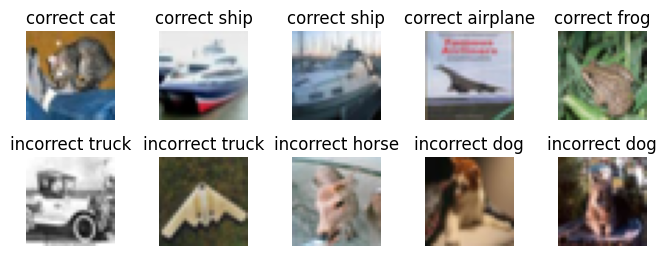

In [ ]:
images = correct + incorrect

fig, axes = plt.subplots(2, 5, figsize=(8,3))
plt.subplots_adjust(wspace=0.5)
for i in range(2):
  prefix = "incorrect" if i else "correct"
  for j in range(5):
    axes[i,j].imshow(images[i*5+j][0], cmap='gray')
    axes[i,j].axis('off')
    axes[i,j].set_title(f'{prefix} {images[i*5+j][1]}')

plt.show()

# Apply Grad-CAM

In [ ]:
# using Grad-CAM
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits


target_layers = model.resnet.encoder.stages[-1].layers[-1].layer
cam = GradCAM(model=HuggingfaceToTensorModelWrapper(model), target_layers=target_layers)

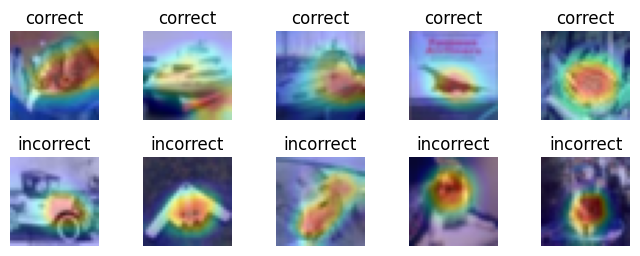

In [ ]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from numpy import asarray

# Construct targes
targets = [ClassifierOutputTarget(i[2]) for i in images]

# Construct input
input_tensor = feature_extractor(images[0][0], return_tensors="pt")['pixel_values']
for i in range(9):
  temp_tensor = feature_extractor(images[i+1][0], return_tensors="pt")['pixel_values']
  input_tensor = torch.cat((input_tensor, temp_tensor), dim=0)

# Grad-CAM
grayscale_cams = cam(input_tensor=input_tensor, targets=targets)

# Merge masks
result_image = []
for index in range(10):
  grayscale_cam = grayscale_cams[index, :]
  visualization = show_cam_on_image(asarray(images[index][0].resize((224,224), resample=Image.BOX))/255, grayscale_cam, use_rgb=True, image_weight=0.7)
  result_image.append(visualization)

# display output
result_image_resized = [Image.fromarray(i, 'RGB').resize((32,32)) for i in result_image]

fig, axes = plt.subplots(2, 5, figsize=(8,3))
plt.subplots_adjust(wspace=0.5)
for i in range(2):
  prefix = "incorrect" if i else "correct"
  for j in range(5):
    axes[i,j].imshow(result_image_resized[i*5+j], cmap='gray')
    axes[i,j].axis('off')
    axes[i,j].set_title(f'{prefix}')

plt.show()